In [1]:
import os
import numpy as np
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.optim as optim
from torchvision.models import ResNet18_Weights


In [18]:
import zipfile

# Specify the path to the ZIP file

zip_path = '/content/drive/MyDrive/dataset/trainingdata.zip'  # Replace with the actual path to your ZIP file

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')

Loading Data and Preprocessing the image

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Set the path to your image directory
data_dir = '/content/sample_data/trainingdata'


# Define the transformation to apply to the images
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.08, 1.0)), #random crop
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.ToTensor(),  # Convert images to tensors  # take random crop of 224 by 224
    # Normalize pixel values using ImageNet dataset values
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),

])
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(size=224),  # Resize images to a consistent size
    transforms.ToTensor(),  # Convert images to tensors
    # Normalize pixel values using ImageNet dataset values
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create an instance of the ImageFolder dataset
dataset = ImageFolder(data_dir, transform=transform_train)

# Split the dataset into train and test sets
train_ratio = 0.8  # Ratio of training data (80%)
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

# Create data loaders for train and test sets
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Print the number of samples in train and test sets
print("Train set size:", len(train_set))
print("Test set size:", len(test_set))
print(train_set.dataset.classes)
print(len(train_set.dataset.classes))


cpu
Train set size: 1947
Test set size: 487
['Michelangelo', 'Pablo_Picasso', 'Paul_Gauguin', 'Peter_Paul_Rubens', 'Piet_Mondrian', 'Raphael', 'Rene_Magritte', 'Sandro_Botticelli', 'Vincent_van_Gogh', 'William_Turner']
10


{'Michelangelo': 0, 'Pablo_Picasso': 1, 'Paul_Gauguin': 2, 'Peter_Paul_Rubens': 3, 'Piet_Mondrian': 4, 'Raphael': 5, 'Rene_Magritte': 6, 'Sandro_Botticelli': 7, 'Vincent_van_Gogh': 8, 'William_Turner': 9}
torch.Size([3, 224, 224])


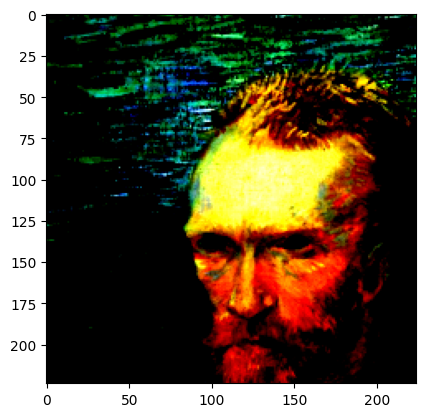

In [20]:
import matplotlib.pyplot as plt

img,label = train_set[0]
img2 = test_set[0]
print(train_set.dataset.class_to_idx)
print(img.shape)
#draw the image
plt.imshow(img.permute(1,2,0))

Building a Baseline CNN

In [21]:
class CNN(nn.Module):

  def __init__(self):
    super(CNN,self).__init__()

    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 2, padding = 1)
    self.relu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size = 2)

    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 2, padding = 1)
    self.relu2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
    
    self.fc1 = nn.Linear(in_features = 32*14*14, out_features = 228)
    self.relu3 = nn.ReLU()

    self.fc2 = nn.Linear(in_features = 228, out_features = 50)

  def forward(self, x):
      x = self.conv1(x)
      x = self.relu1(x)
      x = self.maxpool1(x)

      x = self.conv2(x)
      x = self.relu2(x)
      x = self.maxpool2(x)

      x = x.view(x.size(0), -1)

      x = self.fc1(x)
      x = self.relu3(x)

      x = self.fc2(x)
        
      return x

In [15]:

model = CNN().to(device)

learning_rate = 0.01
num_epochs = 20

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

model.eval()  # Switch to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

Epoch [1/20], Loss: 2.0601
Epoch [2/20], Loss: 2.0863
Epoch [3/20], Loss: 2.1030
Epoch [4/20], Loss: 2.0997
Epoch [5/20], Loss: 1.8558
Epoch [6/20], Loss: 1.9917
Epoch [7/20], Loss: 1.7937
Epoch [8/20], Loss: 2.2143
Epoch [9/20], Loss: 1.8985
Epoch [10/20], Loss: 1.9946
Epoch [11/20], Loss: 1.9782
Epoch [12/20], Loss: 2.2366
Epoch [13/20], Loss: 1.6996
Epoch [14/20], Loss: 1.8327
Epoch [15/20], Loss: 1.9648
Epoch [16/20], Loss: 2.0143
Epoch [17/20], Loss: 1.9336
Epoch [18/20], Loss: 1.8345
Epoch [19/20], Loss: 2.0566
Epoch [20/20], Loss: 1.7639
Test Accuracy: 34.70%


In [ ]:
torch.save(model.state_dict(), 'BaselineCNN.pth')
from google.colab import files
files.download('BaselineCNN.pth')

Building a RESNET with no weights


In [23]:
resnet = models.resnet18()
num_classes = len(train_set.dataset.classes)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet.to(device)
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer=optim.Adam(resnet.parameters(),lr=lr)
print(resnet)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Training Loop

In [ ]:
num_epochs =20
for epoch in range(num_epochs):
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

Epoch 1/20 - Loss: 1.9025
Epoch 2/20 - Loss: 1.7580
Epoch 3/20 - Loss: 1.6844
Epoch 4/20 - Loss: 1.6742
Epoch 5/20 - Loss: 1.6026
Epoch 6/20 - Loss: 1.5893
Epoch 7/20 - Loss: 1.5352
Epoch 8/20 - Loss: 1.5124
Epoch 9/20 - Loss: 1.4712
Epoch 10/20 - Loss: 1.4539
Epoch 11/20 - Loss: 1.4435
Epoch 12/20 - Loss: 1.4650
Epoch 13/20 - Loss: 1.4136


In [ ]:
correct = 0
total = 0

# Put the model in evaluation mode
resnet.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


In [ ]:
correct_top3 = 0
total = 0

# Put the model in evaluation mode
resnet.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = resnet(inputs)
        _, predicted_top3 = outputs.topk(3, 1)  # Get top-3 predicted labels
        
        total += labels.size(0)
        for i in range(labels.size(0)):
            if labels[i] in predicted_top3[i]:
                correct_top3 += 1

test_top3_accuracy = 100 * correct_top3 / total
print(f"Top-3 Test Accuracy: {test_top3_accuracy:.2f}%")


Building a resnet with pre-trained weights


In [ ]:
pretrained_resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_classes = len(train_set.dataset.classes)
pretrained_resnet.fc = nn.Linear(pretrained_resnet.fc.in_features, num_classes)
pretrained_resnet.to(device)
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer=optim.Adam(resnet.parameters(),lr=lr)
print(pretrained_resnet)


In [ ]:
num_epochs =25
for epoch in range(num_epochs):
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = pretrained_resnet(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

In [ ]:
correct = 0
total = 0

# Put the model in evaluation mode
resnet.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = pretrained_resnet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


In [ ]:
correct_top3 = 0
total = 0

# Put the model in evaluation mode
resnet2.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = pretrained_resnet(inputs)
        _, predicted_top3 = outputs.topk(3, 1)  # Get top-3 predicted labels
        
        total += labels.size(0)
        for i in range(labels.size(0)):
            if labels[i] in predicted_top3[i]:
                correct_top3 += 1

test_top3_accuracy = 100 * correct_top3 / total
print(f"Top-3 Test Accuracy: {test_top3_accuracy:.2f}%")
